In [401]:
import os
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import eegbci
from mne.preprocessing import ICA
from scipy.signal import welch
from scipy.stats import zscore

# CONFIG

SUBJECTS = [1, 2, 3, 4, 5]          # Among 109 samples 5 samples are used in this project for grneralization
RUNS = [4,8,12]          # MI runs for imagine opening and closing left or right fist
MI_BAND = (8., 30.)
ICA_BAND = (1., 40.)
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#  DATA QUALITY CHECK FUNCTIONS

def check_missingness(X, label=""):
    print(f"\n=== Missingness Check {label} ===")
    nan_count = np.isnan(X).sum()
    print(f"Total NaNs: {nan_count}")


def check_high_amplitude_artifacts(X, threshold=150e-6, label=""):
    print(f"\n=== High-Amplitude Artifact Check {label} ===")
    max_vals = np.max(np.abs(X), axis=2)
    bad_epochs = np.where(max_vals > threshold)
    print(f"Epochs exceeding {threshold} V: {len(bad_epochs[0])}")


def check_emg_artifacts(X, sfreq, hf_band=(30, 100), label=""):
    print(f"\n=== EMG Artifact Check (High-Frequency Power) {label} ===")
    emg_scores = []
    for trial in X:
        f, Pxx = welch(trial.mean(axis=0), fs=sfreq, nperseg=256)
        hf_power = Pxx[(f >= hf_band[0]) & (f <= hf_band[1])].mean()
        emg_scores.append(hf_power)

    print("Mean HF power:", np.mean(emg_scores))
    print("Max HF power:", np.max(emg_scores))


def detect_outlier_epochs(X, z_thresh=4, label=""):
    print(f"\n=== Outlier Detection (Z-score) {label} ===")
    X_flat = X.reshape(X.shape[0], -1)
    z = np.abs(zscore(X_flat, axis=0))
    outliers = np.where(np.max(z, axis=1) > z_thresh)[0]
    print(f"Outlier epochs detected: {len(outliers)}")


def check_duplicates(X, label=""):
    print(f"\nDuplicate Epoch Check {label}")
    X_flat = X.reshape(X.shape[0], -1)
    unique = np.unique(X_flat, axis=0)
    print(f"Duplicates: {X_flat.shape[0] - unique.shape[0]}")


def check_class_balance(y, label=""):
    print(f"\n=== Class Balance Check {label} ===")
    unique, counts = np.unique(y, return_counts=True)
    print(dict(zip(unique, counts)))


# RAW EPOCHS FOR ARTIFACT PRESENCE CHECK

def load_and_filter_subject(subj):
    print(f"\nLoading subject {subj}")
    raw_files = eegbci.load_data(subj, RUNS)
    raws = [mne.io.read_raw_edf(f, preload=True) for f in raw_files]

    for raw in raws:
        raw.filter(MI_BAND[0], MI_BAND[1], fir_design='firwin')

    raw = mne.concatenate_raws(raws)
    return raw


def extract_raw_epochs(raw):
    events, event_id = mne.events_from_annotations(raw)
    event_id = {'T1': 1, 'T2': 2}

    epochs = mne.Epochs(
        raw, events, event_id,
        tmin=0.5, tmax=2.5,
        baseline=None, preload=True
    )

    X = epochs.get_data()
    y = epochs.events[:, -1] - 1
    return X, y, raw.info['sfreq']



# MAIN: 


def main():
    all_X_raw, all_y_raw = [], []
    sfreq = None

    for subj in SUBJECTS:
        # 1) Load + filter
        raw = load_and_filter_subject(subj)

        # 2) Raw epochs → check presence of artifacts
        X_raw, y_raw, sfreq = extract_raw_epochs(raw)
        all_X_raw.append(X_raw)
        all_y_raw.append(y_raw)

    X_raw_all = np.concatenate(all_X_raw)
    y_raw_all = np.concatenate(all_y_raw)


    print(" RAW DATA QUALITY CHECKS (BEFORE PREPROCESSING)")

    check_missingness(X_raw_all, label="(Raw)")
    check_high_amplitude_artifacts(X_raw_all, label="(Raw)")
    check_emg_artifacts(X_raw_all, sfreq, label="(Raw)")
    detect_outlier_epochs(X_raw_all, label="(Raw)")
    check_duplicates(X_raw_all, label="(Raw)")
    check_class_balance(y_raw_all, label="(Raw)")

    return X_raw_all, y_raw_all, sfreq
if __name__ == "__main__":
    main()



Loading subject 1
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

In [402]:
import numpy as np
import mne
from mne.datasets import eegbci
from mne.preprocessing import ICA
from scipy.signal import welch
from scipy.stats import zscore
from sklearn.utils import resample


# LOAD + FILTER + ICA + ARTIFACT REMOVAL

def preprocess_subject(subj):
    print(f"Preprocessing Subject {subj}")

    # Load raw EDF files

    raw_files = eegbci.load_data(subj, RUNS)
    raws = [mne.io.read_raw_edf(f, preload=True) for f in raw_files]

    # MI-specific bandpass
    for raw in raws:
        raw.filter(MI_BAND[0], MI_BAND[1], fir_design='firwin')

    raw = mne.concatenate_raws(raws)


    # ICA preprocessing

    raw_ica = raw.copy().filter(ICA_BAND[0], ICA_BAND[1], fir_design='firwin')
    raw_ica.set_eeg_reference('average', projection=False)

    ica = ICA(n_components=20, random_state=97, max_iter='auto')
    ica.fit(raw_ica)


    # Detect EOG components

    eog_inds = []
    for ch in ['Fp1.', 'Fp2.', 'F7.', 'F8.']: # These chaneels contains EOG artifacts
        if ch in raw_ica.ch_names:
            inds, _ = ica.find_bads_eog(raw_ica, ch_name=ch)
            eog_inds.extend(inds)
    eog_inds = list(set(eog_inds))


    # Detect EMG components (high-frequency power)

    emg_inds = []
    sources = ica.get_sources(raw_ica).get_data()
    sfreq = raw_ica.info['sfreq']

    for idx in range(ica.n_components_):
        src = sources[idx]
        psd, freqs = mne.time_frequency.psd_array_welch(
            src, sfreq=sfreq, fmin=20., fmax=100., n_fft=512
        )
        if psd.mean() > np.percentile(psd, 75):
            emg_inds.append(idx)

    emg_inds = list(set(emg_inds) - set(eog_inds))


    # Remove ICA components

    ica.exclude = list(set(eog_inds + emg_inds))
    raw_clean = ica.apply(raw.copy())

    return raw_clean



# EPOCHING + CLEANING BAD EPOCHS


def extract_and_clean_epochs(raw_clean):
    events, event_id = mne.events_from_annotations(raw_clean)
    event_id = {'T1': 1, 'T2': 2}

    epochs = mne.Epochs(
        raw_clean, events, event_id,
        tmin=0.5, tmax=2.5,
        baseline=None, preload=True
    )

    X = epochs.get_data()
    y = epochs.events[:, -1] - 1
    sfreq = raw_clean.info['sfreq']


    # Remove missing values

    nan_mask = ~np.isnan(X).any(axis=(1, 2))
    X = X[nan_mask]
    y = y[nan_mask]


    # Remove high-amplitude artifacts

    amp_mask = np.max(np.abs(X), axis=2) < 150e-6
    amp_mask = amp_mask.all(axis=1)
    X = X[amp_mask]
    y = y[amp_mask]


    # Remove outliers (Z-score)

    X_flat = X.reshape(X.shape[0], -1)
    z = np.abs(zscore(X_flat, axis=0))
    outlier_mask = np.max(z, axis=1) < 4
    X = X[outlier_mask]
    y = y[outlier_mask]

    return X, y, sfreq


# CLASS BALANCING (OVERSAMPLING) 
def balance_classes(X, y):
    # Separate classes 
    X0 = X[y == 0] 
    X1 = X[y == 1] 
    n0, n1 = len(X0), len(X1) 
    max_n = max(n0, n1)
    # Oversample minority class 
    if n0 < max_n: 
        X0 = resample(X0, replace=True, n_samples=max_n, random_state=42) 
    if n1 < max_n: 
        X1 = resample(X1, replace=True, n_samples=max_n, random_state=42) 
# Recombine 
    X_bal = np.concatenate([X0, X1]) 
    y_bal = np.array([0]*max_n + [1]*max_n) 

# Shuffle 
    idx = np.random.permutation(len(y_bal)) 
    return X_bal[idx], y_bal[idx]
# FULL PIPELINE FOR MULTIPLE SUBJECTS


def preprocess_all(subjects):
    all_X, all_y = [], []
    sfreq = None

    for subj in subjects:
        raw_clean = preprocess_subject(subj)
        X, y, sfreq = extract_and_clean_epochs(raw_clean)
        all_X.append(X)
        all_y.append(y)

    X_all = np.concatenate(all_X)
    y_all = np.concatenate(all_y)

    X_all, y_all = balance_classes(X_all, y_all)

    print("\nFinal Clean Dataset")
    print("X shape:", X_all.shape)
    print("y shape:", y_all.shape)

    return X_all, y_all, sfreq


In [403]:

#RE-CHECK ARTIFACTS & MISSINGNESS AFTER PREPROCESSING


def run_post_preprocessing_checks(X_clean, y_clean, sfreq):


    # Missingness
    print("\nMissingness After Cleaning ")
    print("Total NaNs:", np.isnan(X_clean).sum())

    # High amplitude artifacts
    print("\nHigh-Amplitude Artifacts After Cleaning")
    max_vals = np.max(np.abs(X_clean), axis=2)
    bad_epochs = np.where(max_vals > 150e-6)
    print(f"Epochs exceeding 150 µV: {len(bad_epochs[0])}")

    # EMG artifacts
    print("\nEMG High-Frequency Power After Cleaning")
    emg_scores = []
    for trial in X_clean:
        f, Pxx = welch(trial.mean(axis=0), fs=sfreq, nperseg=256)
        hf_power = Pxx[(f >= 30) & (f <= 100)].mean()
        emg_scores.append(hf_power)
    print("Mean HF power:", np.mean(emg_scores))
    print("Max HF power:", np.max(emg_scores))

    # Outliers
    print("\nOutliers After Cleaning (Z-score)")
    X_flat = X_clean.reshape(X_clean.shape[0], -1)
    z = np.abs(zscore(X_flat, axis=0))
    outliers = np.where(np.max(z, axis=1) > 4)[0]
    print(f"Outlier epochs detected: {len(outliers)}")

    # Duplicates
    print("\nDuplicate Epochs After Cleaning")
    unique = np.unique(X_flat, axis=0)
    print(f"Duplicates: {X_flat.shape[0] - unique.shape[0]}")

    # Class balance
    print("\nClass Balance After Cleaning")
    unique_y, counts = np.unique(y_clean, return_counts=True)
    print(dict(zip(unique_y, counts)))


In [404]:
X_all, y_all, sfreq = preprocess_all([1, 2, 3, 4, 5])
run_post_preprocessing_checks(X_all, y_all, sfreq)


Preprocessing Subject 1
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

In [405]:
X_raw_all, y_raw_all, sfreq_raw = main()



Loading subject 1
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

In [406]:
def compute_metrics(X, y, sfreq):
    # Missingness
    missing = np.isnan(X).sum()

    # High amplitude artifacts
    max_vals = np.max(np.abs(X), axis=2)
    high_amp = np.sum(max_vals > 150e-6)

    # EMG high-frequency power
    emg_scores = []
    for trial in X:
        f, Pxx = welch(trial.mean(axis=0), fs=sfreq, nperseg=256)
        hf_power = Pxx[(f >= 30) & (f <= 100)].mean()
        emg_scores.append(hf_power)
    emg_mean = np.mean(emg_scores)

    # Outliers
    X_flat = X.reshape(X.shape[0], -1)
    z = np.abs(zscore(X_flat, axis=0))
    outliers = np.sum(np.max(z, axis=1) > 4)

    # Duplicates
    unique = np.unique(X_flat, axis=0)
    duplicates = X_flat.shape[0] - unique.shape[0]

    # Class imbalance (difference between class counts)
    unique_y, counts = np.unique(y, return_counts=True)
    if len(counts) == 2:
        class_imbalance = abs(counts[0] - counts[1])
    else:
        class_imbalance = 0  # fallback

    return [missing, high_amp, emg_mean, outliers, duplicates, class_imbalance]


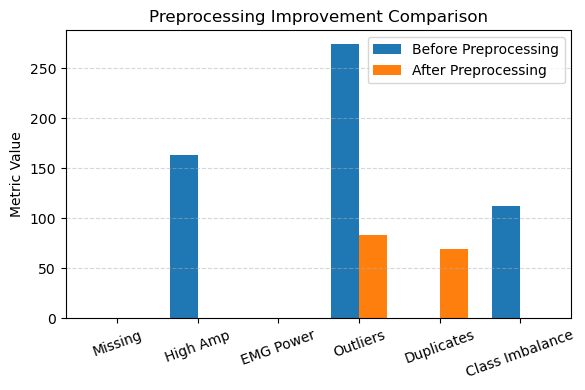

In [407]:
before_metrics = compute_metrics(X_raw_all, y_raw_all, sfreq_raw)
after_metrics = compute_metrics(X_all, y_all, sfreq)

labels = ["Missing", "High Amp", "EMG Power", "Outliers", "Duplicates", "Class Imbalance"]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, before_metrics, width, label='Before Preprocessing')
plt.bar(x + width/2, after_metrics, width, label='After Preprocessing')

plt.xticks(x, labels, rotation=20)
plt.ylabel("Metric Value")
plt.title("Preprocessing Improvement Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Preprocessing Improvement Comparison.png", dpi=300, bbox_inches='tight')

plt.show()


In [408]:
import matplotlib.pyplot as plt

def plot_eeg_overlay(X_raw, X_clean, sfreq, channel=0, trial=0):
    """
    Overlay raw vs cleaned EEG for visual comparison.
    """

    raw_sig = X_raw[trial, channel, :]
    clean_sig = X_clean[trial, channel, :]

    t = np.arange(len(raw_sig)) / sfreq

    plt.figure(figsize=(8, 4))

    plt.plot(t, raw_sig, color='red', alpha=0.6, label='Before Preprocessing')
    plt.plot(t, clean_sig, color='green', alpha=0.8, label='After Preprocessing')

    plt.title(f"EEG Before vs After Preprocessing\nChannel {channel}, Trial {trial}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("EEG Before vs After Preprocessing Channel 10 Trial 1", dpi=300, bbox_inches='tight')
    plt.show()


In [409]:
X_raw_all, y_raw_all, sfreq_raw = main()
X_all, y_all, sfreq = preprocess_all([1,2,3,4,5])



Loading subject 1
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Pralhad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

<Figure size 640x480 with 0 Axes>

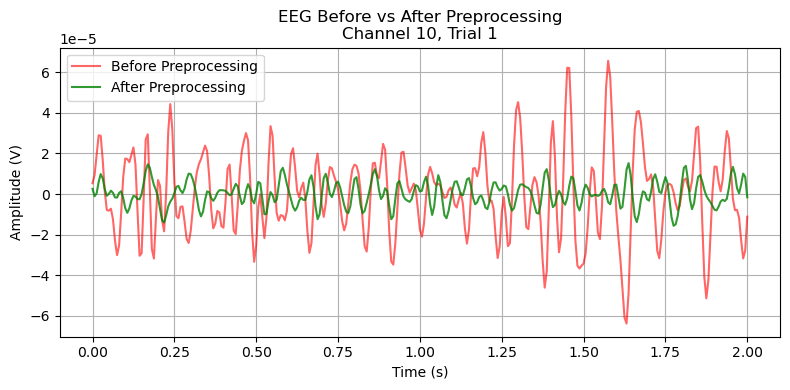

In [410]:
plt.savefig("EEG Before vs After Preprocessing: Channel =10, Trial=1", dpi=300, bbox_inches='tight')
plot_eeg_overlay(X_raw_all, X_all, sfreq, channel=10, trial=1)


In [411]:
from scipy.signal import welch
import numpy as np

def compute_temporal_features(X, sfreq):
    n_trials, n_channels, n_times = X.shape
    feats = []

    for trial in range(n_trials):
        trial_feats = []
        data = X[trial]  # (n_channels, n_times)

        for ch in range(n_channels):
            x = data[ch]

            # Time-domain stats
            mean = x.mean()
            var  = x.var()

            # Bandpower via Welch
            f, Pxx = welch(x, fs=sfreq, nperseg=256)

            mu_band   = (8, 12)
            beta_band = (13, 30)

            mu_power = Pxx[(f >= mu_band[0]) & (f <= mu_band[1])].mean()
            beta_power = Pxx[(f >= beta_band[0]) & (f <= beta_band[1])].mean()

            trial_feats.extend([mean, var, mu_power, beta_power])

        feats.append(trial_feats)

    return np.array(feats)  # shape: (n_trials, n_channels * 4)

In [412]:
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split





# 1) Temporal features
X_train_temp = compute_temporal_features(X_all, sfreq)


# 2) CSP features
csp = CSP(n_components=6)
X_train_csp = csp.fit_transform(X_all, y_all)


# 3) Concatenate
X_train_feat = np.concatenate([X_train_csp, X_train_temp], axis=1)



X_train, X_test, y_train, y_test = train_test_split(
    X_train_feat, y_all, test_size=0.2, stratify=y_all, random_state=42)

X_train_feat=X_train
X_test_feat=X_test
print("Feature shape:", X_train_feat.shape)
print("Feature shape:", X_test_feat.shape)

Computing rank from data with rank=None
    Using tolerance 0.00035 (2.2e-16 eps * 64 dim * 2.5e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Feature shape: (204, 262)
Feature shape: (52, 262)


In [413]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ---------------------------------------------------------
# Pipeline: StandardScaler → Logistic Regression
# ---------------------------------------------------------
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

# ---------------------------------------------------------
# Hyperparameter grid (all meaningful L2 parameters)
# ---------------------------------------------------------
param_grid = {
    "logreg__penalty": ["l1","l2"], # L2 regularization  
    "logreg__C": [0.01, 0.1, 1, 2],         # regularization strength
    "logreg__solver": ["lbfgs", "liblinear"],      # both support L2
    "logreg__class_weight": ["balanced"],    # compare balanced vs unbalanced
    "logreg__max_iter": [100,500,1000],   # ensure convergence
    "logreg__random_state": [42]                   # reproducibility
}

# ---------------------------------------------------------
# Stratified 5-fold CV (best for EEG)
# ---------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------------------------------------
# Grid Search
# ---------------------------------------------------------
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",   # best for EEG imbalance
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# ---------------------------------------------------------
# Fit
# ---------------------------------------------------------
grid.fit(X_train_feat, y_train)

print("\nBest parameters:", grid.best_params_)
print("Best CV F1-macro:", grid.best_score_)

# ---------------------------------------------------------
# Evaluate on test set
# ---------------------------------------------------------
best_model = grid.best_estimator_
test_acc = best_model.score(X_test_feat, y_test)

print("\nTest Accuracy:", test_acc)


Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'logreg__C': 2, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__random_state': 42, 'logreg__solver': 'liblinear'}
Best CV F1-macro: 0.7642534841739248

Test Accuracy: 0.9038461538461539


C:\Users\Pralhad\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Pralhad\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Pralhad\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Pralhad\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_esti

In [415]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# Logistic Regression pipeline 
# ---------------------------------------------------------
logreg_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty='l2',             #regularization 
        C=2,                    # regularization strength (tune if needed)
        class_weight='balanced',  # handles class imbalance
        max_iter=100,            # ensure convergence
        solver='liblinear',           # stable for L2 + multinomial/binary
        random_state=42
    ))
])

# Train
logreg_clf.fit(X_train_feat, y_train)

# Evaluate
acc = logreg_clf.score(X_test_feat, y_test)
print("Logistic Regression accuracy:", acc)


Logistic Regression accuracy: 0.9038461538461539


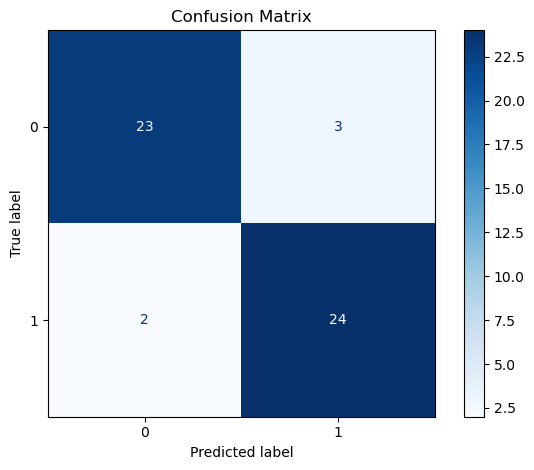

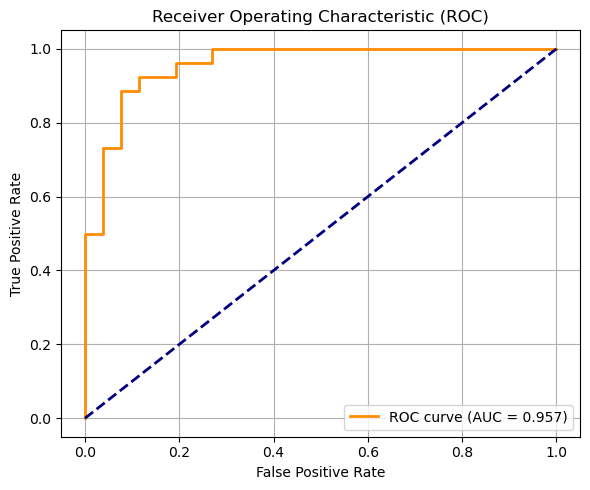

In [416]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
import numpy as np

# ---------------------------------------------------------
# Predictions
# ---------------------------------------------------------
y_pred = logreg_clf.predict(X_test_feat)

# For ROC curve, we need probability scores
# Logistic Regression: predict_proba

try:
    y_scores = logreg_clf.predict_proba(X_test_feat)[:, 1]
except:
    y_scores = logreg_clf.decision_function(X_test_feat)

# ---------------------------------------------------------
# Confusion Matrix
# ---------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# ROC Curve
# ---------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [417]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import numpy as np


# Basic metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)          # Sensitivity / True Positive Rate
f1 = f1_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1)

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Left MI', 'Right MI']))


Accuracy: 0.9038461538461539
Precision: 0.8888888888888888
Recall (Sensitivity): 0.9230769230769231
Specificity: 0.8846153846153846
F1 Score: 0.9056603773584906

Classification Report:
              precision    recall  f1-score   support

     Left MI       0.92      0.88      0.90        26
    Right MI       0.89      0.92      0.91        26

    accuracy                           0.90        52
   macro avg       0.90      0.90      0.90        52
weighted avg       0.90      0.90      0.90        52



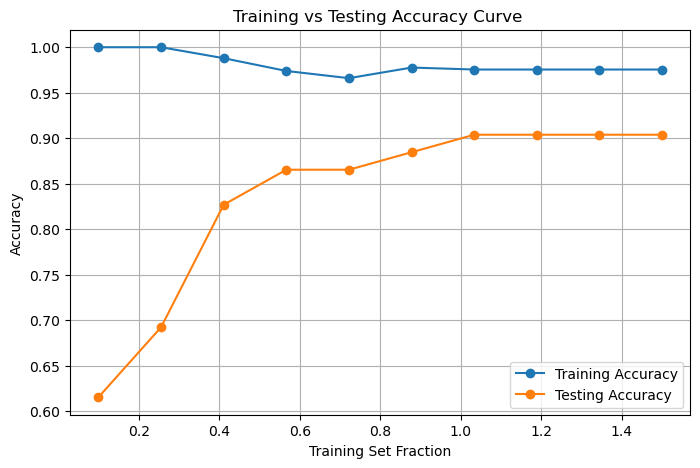

In [418]:
import matplotlib.pyplot as plt
import numpy as np

train_acc_list = []
test_acc_list = []
sizes = np.linspace(0.1, 1.5, 10)

for s in sizes:
    n = int(len(X_train_feat) * s)

    # Train on first n samples
    logreg_clf.fit(X_train_feat[:n], y_train[:n])

    # Training accuracy
    train_acc = logreg_clf.score(X_train_feat[:n], y_train[:n])
    train_acc_list.append(train_acc)

    # Testing accuracy
    test_acc = logreg_clf.score(X_test_feat, y_test)
    test_acc_list.append(test_acc)

# Plot
plt.figure(figsize=(8,5))
plt.plot(sizes, train_acc_list, 'o-', label="Training Accuracy")
plt.plot(sizes, test_acc_list, 'o-', label="Testing Accuracy")
plt.xlabel("Training Set Fraction")
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy Curve ")
plt.grid(True)
plt.legend()
plt.show()


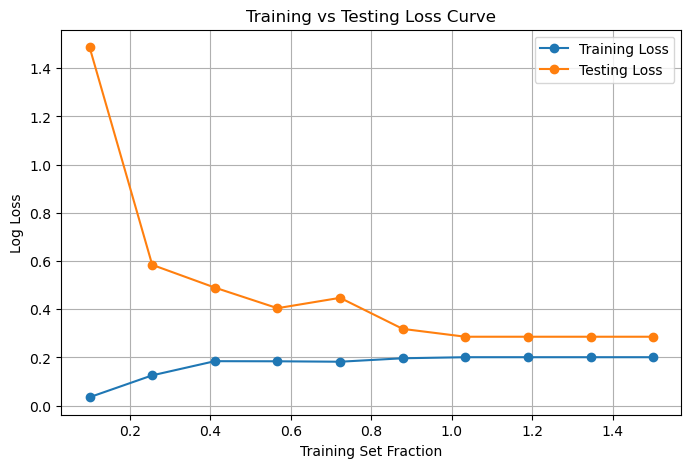

In [419]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

train_loss_list = []
val_loss_list = []

sizes = np.linspace(0.1, 1.5, 10)

for s in sizes:
    n = int(len(X_train_feat) * s)

    # Train on first n samples
    logreg_clf.fit(X_train_feat[:n], y_train[:n])

    # Predict probabilities
    train_probs = logreg_clf.predict_proba(X_train_feat[:n])
    val_probs = logreg_clf.predict_proba(X_test_feat)

    # Compute log-loss
    train_loss = log_loss(y_train[:n], train_probs)
    val_loss = log_loss(y_test, val_probs)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

# Plot
plt.figure(figsize=(8,5))
plt.plot(sizes, train_loss_list, 'o-', label="Training Loss")
plt.plot(sizes, val_loss_list, 'o-', label="Testing Loss")
plt.xlabel("Training Set Fraction")
plt.ylabel("Log Loss")
plt.title("Training vs Testing Loss Curve")
plt.grid(True)
plt.legend()
plt.show()


In [420]:
#Latency measurement
import time
import numpy as np

def measure_latency(model, X, runs=1000):
    latencies = []

    for _ in range(runs):
        idx = np.random.randint(0, len(X))
        sample = X[idx].reshape(1, -1)

        start = time.perf_counter()
        model.predict(sample)
        end = time.perf_counter()

        latencies.append((end - start) * 1000)  # ms

    latencies = np.array(latencies)
    return {
        "p50_ms": np.percentile(latencies, 50),
        "p90_ms": np.percentile(latencies, 90),
        "mean_ms": latencies.mean()
    }


In [421]:
results = measure_latency(best_model, X_test_feat) 
print(results)

{'p50_ms': 0.1952500024344772, 'p90_ms': 0.3438099985942245, 'mean_ms': 0.25657069994485937}


In [422]:
#TRAINING Time measurement
import time

start = time.perf_counter()
logreg_clf.fit(X_train_feat, y_train)
end = time.perf_counter()

training_time = end - start
print("Training time (seconds):", training_time)


Training time (seconds): 0.015174199987086467


In [423]:
#Peak Memory usage measurement
from memory_profiler import memory_usage

def train_model():
    logreg_clf.fit(X_train_feat, y_train)

mem_usage = memory_usage(train_model)
print("Peak memory (MB):", max(mem_usage))


Peak memory (MB): 416.17578125


In [424]:
#Model Size measurement
import joblib
import os

joblib.dump(logreg_clf, "logreg_model.pkl")
print("Model size (KB):", os.path.getsize("logreg_model.pkl") / 1024)


Model size (KB): 9.525390625


In [425]:
#FLOPs measurement
n_features = X_train_feat.shape[1]
flops = 2 * n_features
print("Approx FLOPs per inference:", flops)


Approx FLOPs per inference: 524


In [426]:
#Estimated CO2 emissions
from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
tracker.start()

logreg_clf.fit(X_train_feat, y_train)

emissions = tracker.stop()
print("Estimated CO2 emissions (kg):", emissions)


[codecarbon WARNING @ 20:58:44] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:58:44] [setup] RAM Tracking...
[codecarbon INFO @ 20:58:44] [setup] CPU Tracking...
[codecarbon WARNING @ 20:58:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 20:58:46] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz
[codecarbon WARNING @ 20:58:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:58:46] [setup] GPU Tracking...
[codecarbon INFO @ 20:58:46] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 20:58:46] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "C:\Users\Pralhad\anaconda3\Lib\site-packages\codecarbon\core\gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(se

Estimated CO2 emissions (kg): 1.4540192757850454e-09


In [427]:
#Throughput Measurement
import time
import numpy as np

N = 5000
samples = X_test_feat[:N]

start = time.perf_counter()
logreg_clf.predict(samples)
end = time.perf_counter()

throughput = N / (end - start)
print("Throughput (samples/sec):", throughput)


Throughput (samples/sec): 3472463.3497954886


In [428]:
#Memory Footprint Measurement
import tracemalloc

tracemalloc.start()
logreg_clf.predict(X_test_feat[:1])
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print("Inference memory (KB):", peak / 1024)


Inference memory (KB): 163.9541015625


In [429]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('input', FloatTensorType([None, X_train_feat.shape[1]]))]
onnx_model = convert_sklearn(logreg_clf, initial_types=initial_type)

with open("logreg.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [430]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantize_dynamic("logreg.onnx", "logreg_quant.onnx",
                 weight_type=QuantType.QInt8)


In [431]:
import onnxruntime as ort
import numpy as np
import time

session = ort.InferenceSession("logreg_quant.onnx")

input_name = session.get_inputs()[0].name
x = X_test_feat[0].astype(np.float32).reshape(1, -1)

start = time.perf_counter()
session.run(None, {input_name: x})
end = time.perf_counter()

print("ONNX quantized latency (ms):", (end - start) * 1000)


ONNX quantized latency (ms): 3.315800000564195


In [432]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# LDA pipeline
# ---------------------------------------------------------
lda_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),   # LDA benefits from scaling
    ("lda", LinearDiscriminantAnalysis(
        solver='svd',               # default, stable for EEG
        shrinkage=None,             # can tune if needed
        priors=None                 # let model infer class priors
    ))
])

# Train
lda_clf.fit(X_train_feat, y_train)

# Evaluate
acc_lda = lda_clf.score(X_test_feat, y_test)
print("LDA accuracy:", acc_lda)

LDA accuracy: 0.8076923076923077


In [433]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import numpy as np
y_pred = lda_clf.predict(X_test_feat)
# Basic metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)          # Sensitivity / True Positive Rate
f1 = f1_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1)

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Left MI', 'Right MI']))


Accuracy: 0.8076923076923077
Precision: 0.7666666666666667
Recall (Sensitivity): 0.8846153846153846
Specificity: 0.7307692307692307
F1 Score: 0.8214285714285714

Classification Report:
              precision    recall  f1-score   support

     Left MI       0.86      0.73      0.79        26
    Right MI       0.77      0.88      0.82        26

    accuracy                           0.81        52
   macro avg       0.82      0.81      0.81        52
weighted avg       0.82      0.81      0.81        52



In [434]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# Linear SVM pipeline
# ---------------------------------------------------------
svm_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel='linear',
        C=1.0,
        class_weight='balanced',   # handles class imbalance
        probability=True,          # needed for ROC/AUC
        random_state=42
    ))
])

# Train
svm_clf.fit(X_train_feat, y_train)

# Evaluate
acc_svm = svm_clf.score(X_test_feat, y_test)
print("Linear SVM accuracy:", acc_svm)


Linear SVM accuracy: 0.8653846153846154


In [435]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import numpy as np
y_pred = svm_clf.predict(X_test_feat)
# Basic metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)          # Sensitivity / True Positive Rate
f1 = f1_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1)

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Left MI', 'Right MI']))


Accuracy: 0.8653846153846154
Precision: 0.8275862068965517
Recall (Sensitivity): 0.9230769230769231
Specificity: 0.8076923076923077
F1 Score: 0.8727272727272727

Classification Report:
              precision    recall  f1-score   support

     Left MI       0.91      0.81      0.86        26
    Right MI       0.83      0.92      0.87        26

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.86        52
weighted avg       0.87      0.87      0.86        52



In [438]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# Random Forest pipeline
# ---------------------------------------------------------
rf_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),   # optional but helps with temporal features
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# Train
rf_clf.fit(X_train_feat, y_train)

# Evaluate
acc_rf = rf_clf.score(X_test_feat, y_test)
print("Random Forest accuracy:", acc_rf)


Random Forest accuracy: 0.8461538461538461


In [439]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import numpy as np
y_pred = rf_clf.predict(X_test_feat)
# Basic metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)          # Sensitivity / True Positive Rate
f1 = f1_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1)

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Left MI', 'Right MI']))


Accuracy: 0.8461538461538461
Precision: 0.8214285714285714
Recall (Sensitivity): 0.8846153846153846
Specificity: 0.8076923076923077
F1 Score: 0.8518518518518519

Classification Report:
              precision    recall  f1-score   support

     Left MI       0.88      0.81      0.84        26
    Right MI       0.82      0.88      0.85        26

    accuracy                           0.85        52
   macro avg       0.85      0.85      0.85        52
weighted avg       0.85      0.85      0.85        52

